In [1]:
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import os
import torch.optim as optim
from probe_experiment import ProbeExperiment
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
with open('data/annotations_with_at_least_one_top10_kw.pkl', 'rb') as file:
    annotations = pkl.load(file)

keywords = ['territory', 'cut', 'sente', 'shape', 'moyo',
            'ko', 'invasion', 'influence', 'wall', 'eye']

In [3]:
from models import *
go_model = load_go_model_from_ckpt('model_ckpt.pth.tar', rm_prefix=True)
models = [CutModel(go_model, i).cuda() for i in range(8)]

In [4]:
layer_n_channels = [8, 64, 64, 64, 48, 48, 32, 32]
layer_dims = [n*19*19 for n in layer_n_channels]
def init_probe_model(layer):
    return nn.Linear(layer_dims[layer], len(keywords)).cuda()

In [5]:
from probe_dataset import *
import random
random.shuffle(annotations)
dataset = SPBoWDataset(annotations, keywords)
dataset = load_to_memory(dataset)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79206/79206 [01:46<00:00, 746.37it/s]


In [7]:
losses, aucs = {}, {}
for val_idx in range(10):
    chunk_size = len(dataset) // 10
    train_split = dataset[:val_idx*chunk_size] + dataset[(val_idx+1)*chunk_size:]
    val_split = dataset[val_idx*chunk_size:(val_idx+1)*chunk_size]
    exp = ProbeExperiment(train_split, val_split, keywords)
    probes = [init_probe_model(i) for i in range(8)]
    
    _, labels = exp.predict_labels(models[0], probes[0], val_split)
    baseline_preds = np.tile(np.mean(labels, axis=0), (len(labels), 1))
    bs_loss = nn.BCEWithLogitsLoss()(torch.from_numpy(baseline_preds), torch.from_numpy(labels))
    print('Baseline loss %f' % bs_loss)
    for kw in range(len(keywords)):
        aucs['val%d_kw%d_bl' % (val_idx, kw)] = roc_auc_score(labels[:, kw], baseline_preds[:, kw])
        losses['val%d_kw%d_bl' % (val_idx, kw)] = nn.BCEWithLogitsLoss()(
        torch.from_numpy(baseline_preds[:, kw]), torch.from_numpy(labels[:, kw]))
    
    for depth in range(len(models)):
        print('INFO val%d depth%d' % (val_idx, depth))
        feat_model = models[depth]
        probe = probes[depth]
        config = {'num_epochs':5, 'batch_size':512,
                 'criterion':nn.BCEWithLogitsLoss(),
                 'optimizer':optim.Adam(probe.parameters(), lr=0.001),
                 'write_log':False, 'save_ckpt':False}        
        exp.run('cross_val/depth%d_val%d_probe'% (depth, val_idx), feat_model, probe, config)
        preds, labels = exp.predict_labels(feat_model, probe, val_split)
        for kw in range(len(keywords)):
            aucs['val%d_depth%d_kw%d' % (val_idx, depth, kw)] = roc_auc_score(labels[:, kw], preds[:, kw])
            losses['val%d_depth%d_kw%d' % (val_idx, depth, kw)] = nn.BCEWithLogitsLoss()(
                torch.from_numpy(preds[:, kw]), torch.from_numpy(labels[:, kw]))
with open('cross_val_losses.pkl', 'wb') as f:
    pkl.dump(losses, f)
with open('cross_val_aucs.pkl', 'wb') as f:
    pkl.dump(aucs, f)

Baseline loss 0.734619
INFO val0 depth0
[LOG] epoch 0 loss 0.320677, new best
[LOG] epoch 1 loss 0.319462, new best
[LOG] epoch 2 loss 0.318376, new best
[LOG] epoch 3 loss 0.318329, new best
[LOG] epoch 4 loss 0.318604
INFO val0 depth1
[LOG] epoch 0 loss 0.316913, new best
[LOG] epoch 1 loss 0.315885, new best
[LOG] epoch 2 loss 0.315726, new best
[LOG] epoch 3 loss 0.319589
[LOG] epoch 4 loss 0.318740
INFO val0 depth2
[LOG] epoch 0 loss 0.314456, new best
[LOG] epoch 1 loss 0.314172, new best
[LOG] epoch 2 loss 0.315484
[LOG] epoch 3 loss 0.316554
[LOG] epoch 4 loss 0.315511
INFO val0 depth3
[LOG] epoch 0 loss 0.318971, new best
[LOG] epoch 1 loss 0.318146, new best
[LOG] epoch 2 loss 0.318534
[LOG] epoch 3 loss 0.320462
[LOG] epoch 4 loss 0.323312
INFO val0 depth4
[LOG] epoch 0 loss 0.313087, new best
[LOG] epoch 1 loss 0.315405
[LOG] epoch 2 loss 0.315689
[LOG] epoch 3 loss 0.319534
[LOG] epoch 4 loss 0.321060
INFO val0 depth5
[LOG] epoch 0 loss 0.313484, new best
[LOG] epoch 1 los

[LOG] epoch 2 loss 0.324124
[LOG] epoch 3 loss 0.322086
[LOG] epoch 4 loss 0.326965
INFO val5 depth4
[LOG] epoch 0 loss 0.315385, new best
[LOG] epoch 1 loss 0.316357
[LOG] epoch 2 loss 0.319535
[LOG] epoch 3 loss 0.320539
[LOG] epoch 4 loss 0.322562
INFO val5 depth5
[LOG] epoch 0 loss 0.313033, new best
[LOG] epoch 1 loss 0.312419, new best
[LOG] epoch 2 loss 0.312498
[LOG] epoch 3 loss 0.313189
[LOG] epoch 4 loss 0.314614
INFO val5 depth6
[LOG] epoch 0 loss 0.315454, new best
[LOG] epoch 1 loss 0.313266, new best
[LOG] epoch 2 loss 0.312025, new best
[LOG] epoch 3 loss 0.311530, new best
[LOG] epoch 4 loss 0.311286, new best
INFO val5 depth7
[LOG] epoch 0 loss 0.318757, new best
[LOG] epoch 1 loss 0.315479, new best
[LOG] epoch 2 loss 0.313950, new best
[LOG] epoch 3 loss 0.312803, new best
[LOG] epoch 4 loss 0.312269, new best
Baseline loss 0.734690
INFO val6 depth0
[LOG] epoch 0 loss 0.321924, new best
[LOG] epoch 1 loss 0.320963, new best
[LOG] epoch 2 loss 0.319902, new best
[LOG

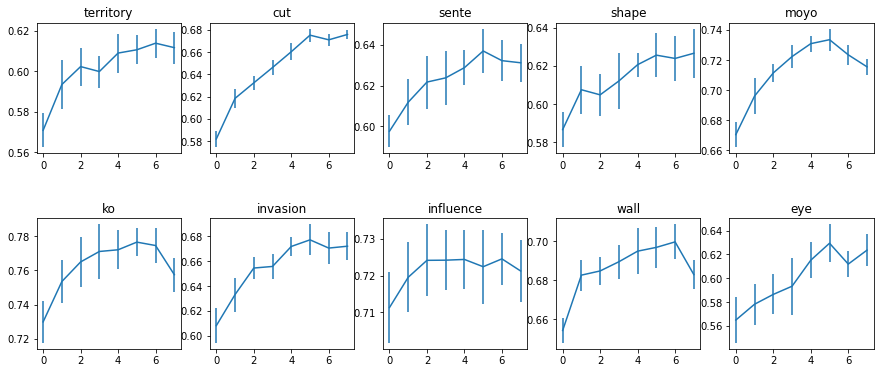

In [10]:
from math import ceil
import matplotlib.pyplot as plt
import numpy as np

cols = 5
rows = ceil(len(keywords)/cols)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    kw_aucs = []
    kw_auc_stds = []
    for depth in range(8):
        auc_ls = [aucs['val%d_depth%d_kw%d' % (i, depth, kw)] for i in range(10)]
        kw_aucs.append(np.mean(auc_ls))
        kw_auc_stds.append(np.std(auc_ls))    
    axs[kw//cols][kw%cols].errorbar(range(8), kw_aucs, kw_auc_stds)
    #axs[kw//cols][kw%cols].plot(range(8), [0.5]*8)
    axs[kw//cols][kw%cols].set_title(keywords[kw])

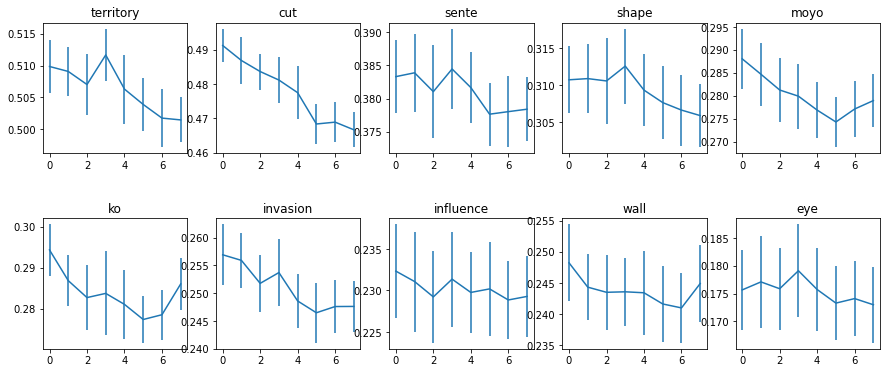

In [11]:
cols = 5
rows = ceil(len(keywords)/cols)
plt.rcParams['figure.figsize'] = (3*cols, 3*rows)
fig, axs = plt.subplots(rows, cols)
fig.subplots_adjust(hspace=0.5)

for kw in range(len(keywords)):
    kw_losses = []
    kw_loss_stds = []
    for depth in range(8):
        loss_ls = [losses['val%d_depth%d_kw%d' % (i, depth, kw)] for i in range(10)]
        kw_losses.append(np.mean(loss_ls))
        kw_loss_stds.append(np.std(loss_ls))
    axs[kw//cols][kw%cols].errorbar(range(8), kw_losses, kw_loss_stds)
    axs[kw//cols][kw%cols].set_title(keywords[kw])